In [1]:
import jax
import jax.numpy as jnp
from jax.numpy.linalg import lstsq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
from torch.nn.utils import parameters_to_vector, vector_to_parameters

import time
import pandas as pd
from scipy.integrate import quad
from copy import copy
import sys
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('poisson_1d'), '..')))

from tedeous.data import Domain, Conditions, Equation
from tedeous.model import Model
from tedeous.callbacks import early_stopping
from tedeous.optimizers.optimizer import Optimizer
from tedeous.eval import integration

### эксперименты с натуральным градиентом

In [ ]:

torch.set_default_device('cuda')
torch.set_default_dtype(torch.float64)
jax.config.update("jax_enable_x64", True)

def replace_none_with_zero(tuple_data):
    if isinstance(tuple_data, torch.Tensor):
        tuple_data[tuple_data == None] = 0
    elif tuple_data is None:
        tuple_data = torch.tensor([0.])
    elif isinstance(tuple_data, tuple):
        new_tuple = tuple(replace_none_with_zero(item) for item in tuple_data)
        return new_tuple
    return tuple_data

def gramian(net, residuals):
        # Compute the jacobian on batched data
    def jacobian():
        jac = []
        loss = residuals
        for l in loss:
            j = torch.autograd.grad(l, net.parameters(), retain_graph=True, allow_unused=True)
            j = replace_none_with_zero(j)
            j = parameters_to_vector(j).reshape(1, -1)
            jac.append(j)
        return torch.cat(jac)

    J = jacobian()
    return 1.0 / len(residuals) * J.T @ J

def grid_line_search_factory(loss, steps):

    def loss_at_step(step, model, tangent_params):
        params = parameters_to_vector(model.parameters())
        new_params = params - step*tangent_params
        vector_to_parameters(new_params, model.parameters())
        loss_val, _ = loss()
        vector_to_parameters(params, model.parameters())
        return loss_val

    def grid_line_search_update(model, tangent_params):

        losses = []
        for step in steps:
            losses.append(loss_at_step(step, model, tangent_params).reshape(1))
        losses = torch.cat(losses)
        step_size = steps[torch.argmin(losses)]

        params = parameters_to_vector(model.parameters())
        new_params = params - step_size*tangent_params
        vector_to_parameters(new_params, model.parameters())

        return step_size

    return grid_line_search_update

a = 4

def u(x):
  return torch.sin(torch.pi * a * x)

def u_x(x):
   return (torch.pi * a) * torch.cos(torch.pi * a * x)

def u_xx(x):
  return -(torch.pi * a) ** 2 * torch.sin(torch.pi * a * x)


def poisson_NGD(grid_res):
    exp_dict_list = []
    start = time.time()
    l_op = 1
    l_bound = 1

    grid_steps = torch.linspace(0, 30, 31)
    steps = 0.5**grid_steps

    x0 = 0
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], grid_res, dtype='float64')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)
    
    net = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 32),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 1)
    )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=l_op, lambda_bound=l_bound)

    ls_update = grid_line_search_factory(model.solution_cls.evaluate, steps)

    for iteration in range(100):
        loss, _ = model.solution_cls.evaluate()
        grads = torch.autograd.grad(loss, model.net.parameters(), retain_graph=True, allow_unused=True)
        grads = replace_none_with_zero(grads)
        f_grads = parameters_to_vector(grads)

        int_res = model.solution_cls.operator._pde_compute()
        bval, true_bval, _, _ = model.solution_cls.boundary.apply_bcs()
        bound_res = bval-true_bval

        # assemble gramian
        G_int  = gramian(model.net, int_res)

        G_bdry = gramian(model.net, bound_res)
        G      = G_int + G_bdry

        # Marquardt-Levenberg
        Id = torch.eye(len(G))
        G = torch.min(torch.tensor([loss, 0.0])) * Id + G
        # compute natural gradient
        G = jnp.array(G.detach().cpu().numpy(), dtype=jnp.float64)
        f_grads =jnp.array(f_grads.detach().cpu().numpy(), dtype=jnp.float64)
        f_nat_grad = lstsq(G, f_grads)[0]
        f_nat_grad = torch.from_numpy(np.array(f_nat_grad)).to(torch.float64).to('cuda')

        # one step of NGD
        actual_step = ls_update(model.net, f_nat_grad)
        if iteration%10 == 0:
            print('iteration= ', iteration)
            print('step= ', actual_step.item())
            print('loss=' , model.solution_cls.evaluate()[0].item())
    end = time.time()
    time_NGD = end-start
    
    grid = domain.build('autograd')
    grid_test = torch.linspace(0, 1, 100).reshape(-1, 1)
    error_train = torch.sqrt(torch.mean((u(grid).reshape(-1) - net(grid).reshape(-1)) ** 2))
    error_test = torch.sqrt(torch.mean((u(grid_test).reshape(-1) - net(grid_test).reshape(-1)) ** 2))
    loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    lu_f = model.solution_cls.operator.operator_compute()

    lu_f, _ = integration(lu_f, grid)

    #########
    exp_dict_list.append({'grid_res': grid_res,
                          'error_train_NGD': error_train.item(),
                          'error_test_NGD': error_test.item(),
                          'loss_NGD': loss.item(),
                          "lu_f_NGD": lu_f.item(),
                          'time_NGD': time_NGD,
                          'type':'poisson_1d'})
    print(f'error = {error_test}')
    return exp_dict_list

nruns = 1
###########################
exp_dict_list = []

for grid_res in [5, 10, 50, 100, 500, 1000, 2000, 3000]:
    for _ in range(nruns):
        exp_dict_list.append(poisson_NGD(grid_res))

exp_dict_list_flatten = [item for sublist in exp_dict_list for item in sublist]
df = pd.DataFrame(exp_dict_list_flatten)
df.to_csv('poisson_NGD.csv')
###########################

### эксперименты с оценками сходимости

In [2]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('poisson1d'), '..')))

from tedeous.data import Domain, Conditions, Equation
from tedeous.model import Model
from tedeous.models import mat_model, Fourier_embedding
from tedeous.callbacks import plot, early_stopping, adaptive_lambda
from tedeous.optimizers.optimizer import Optimizer
from tedeous.device import solver_device
from tedeous.eval import integration

In [3]:
solver_device('cuda')

a = 4

def u(x):
  return torch.sin(torch.pi * a * x)

def u_x(x):
   return (torch.pi * a) * torch.cos(torch.pi * a * x)

def u_xx(x):
  return -(torch.pi * a) ** 2 * torch.sin(torch.pi * a * x)

def u_net(net, x):
    net = net.to('cpu')
    x = x.to('cpu')
    return net(x).detach()

def u_net_x(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    x.requires_grad_()
    u = net(x)
    u_x = torch.autograd.grad(sum(u), x)[0]
    return u_x.detach()

def u_net_xx(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    x.requires_grad_()
    u = net(x)
    u_x = torch.autograd.grad(sum(u), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(sum(u_x), x)[0]
    return u_xx.detach()

def c2_norm(net, x):
    norms = [(u, u_net), (u_x, u_net_x), (u_xx, u_net_xx)]
    norm = 0
    for exact, predict in norms:
        norm += torch.max(abs(exact(x).cpu().reshape(-1) - predict(net, x).cpu().reshape(-1)))
    return norm.detach().cpu().numpy()

def l2_norm(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    predict = net(x).detach().cpu().reshape(-1)
    exact = u(x).detach().cpu().reshape(-1)
    l2_norm = torch.sqrt(sum((predict-exact)**2))
    return l2_norm.detach().cpu().numpy()

def l2_norm_mat(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    predict = net.detach().cpu().reshape(-1)
    exact = u(x).detach().cpu().reshape(-1)
    l2_norm = torch.sqrt(sum((predict-exact)**2))
    return l2_norm.detach().cpu().numpy()

def experiment(N):
    exp_dict_list = []

    x0 = 0
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    lu_f = model.solution_cls.operator.operator_compute()

    lu_f, _ = integration(lu_f, grid)

    lu = u_net_xx(net, grid)

    lu, _ = integration(lu, grid)

    exp_dict_list.append({'grid_res': N,
                          'l2_loss': l2_loss,
                          "lu_f": lu_f.item(),
                          "lu": lu.item(),
                          'l2_norm': l2_norm(net, grid),
                          'c2_norm': c2_norm(net, grid),
                          'type':'Poisson'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid))
    print('l2_norm = ', l2_norm(net, grid))
    print('lu_f = ', lu_f.item())
    print('lu = ', lu.item())

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_PSO(N):
    exp_dict_list = []

    x0 = 0
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_pinn = l2_norm(net, grid)
    print('l2_norm = ', l2_pinn)
    net = net.to('cuda')

    ########

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6, info_string_every=1000)

    optimizer = Optimizer('PSO', {'pop_size': 50, #30
                                  'b': 0.4, #0.5
                                  'c2': 0.5, #0.05
                                  'c1': 0.5, 
                                  'variance': 5e-2,
                                  'lr': 1e-4})

    model.train(optimizer, 2e4, save_model=False, callbacks=[cb_es])


    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    lu_f = model.solution_cls.operator.operator_compute()

    lu_f, _ = integration(lu_f, grid)

    lu = u_net_xx(net, grid)

    lu, _ = integration(lu, grid)

    exp_dict_list.append({'grid_res': N,
                          'l2_loss': l2_loss,
                          'l2_PSO': l2_norm(net, grid),
                          'l2_pinn': l2_pinn,
                          "lu_f": lu_f.item(),
                          "lu": lu.item(),
                          'l2_norm': l2_norm(net, grid),
                          'c2_norm': c2_norm(net, grid),
                          'type':'Poisson_PSO'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid))
    print('l2_norm = ', l2_norm(net, grid))
    print('lu_f = ', lu_f.item())
    print('lu = ', lu.item())

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_mat(N):
    solver_device('cuda')

    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x']
    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    grid = torch.linspace(-1, 1, N+1).reshape(-1,1)

    l2_pinn = l2_norm(net, grid)
    print('l2_norm = ', l2_pinn)
    net = net.to('cuda')


    ########
    solver_device('cpu')

    net = net(grid).reshape(1, N+1).detach().cpu()

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x']
    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    model = Model(net, domain, equation, boundaries)

    model.compile('mat', lambda_operator=1, lambda_bound=1, derivative_points=3)

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('LBFGS', {'lr': 1e-2})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid = domain.build('mat')

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_mat': l2_norm_mat(net, grid), 'l2_pinn': l2_pinn, 'type':'Poisson_mat'})

    print('grid_res=', N)
    print('l2_norm = ', l2_norm_mat(net, grid))

    plt.plot(grid.detach().cpu().numpy().reshape(-1), u(grid).detach().cpu().numpy().reshape(-1), label='Exact')
    plt.plot(grid.detach().cpu().numpy().reshape(-1), net.detach().cpu().numpy().reshape(-1), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_neur(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], 300, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    img_dir = os.path.join(os.path.dirname('examples'), 'poisson_img')
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    cb_plots = plot.Plots(save_every=None, print_every=None, img_dir=img_dir)

    optimizer = Optimizer('Adam', {'lr': 1e-4}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_plots, cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'NN_res': N, 'l2_loss': l2_loss, 'l2_norm': l2_norm(net, grid_error), 'c2_norm': c2_norm(net, grid_error), 'type':'Poisson'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_lam(N):
    exp_dict_list = []

    x0 = 0
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6, normalized_loss=True)
    cb_lam = adaptive_lambda.AdaptiveLambda()

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es, cb_lam])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    lu_f = model.solution_cls.operator.operator_compute()

    lu_f, _ = integration(lu_f, grid)

    lu = u_net_xx(net, grid)

    lu, _ = integration(lu, grid)

    exp_dict_list.append({'grid_res': N,
                          'l2_loss': l2_loss,
                          "lu_f": lu_f.item(),
                          "lu": lu.item(),
                          'l2_norm': l2_norm(net, grid),
                          'c2_norm': c2_norm(net, grid),
                          'type':'Poisson'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid))
    print('l2_norm = ', l2_norm(net, grid))
    print('lu_f = ', lu_f.item())
    print('lu = ', lu.item())

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

    return exp_dict_list

def experiment_fourier(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    FFL = Fourier_embedding(L=[2], M=[1])

    out = FFL.out_features

    net = torch.nn.Sequential(
            FFL,
            torch.nn.Linear(out, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-3}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_norm': l2_norm(net, grid_error), 'type':'Poisson'})

    print('grid_res=', N)
    # print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

### из всех вариаций экспериментов, улучшающим базовый пинн было PSO.

CUDA is available and used.


In [4]:
# Создайте список для каждой части
part1 = np.arange(2, 10, 3)
part2 = np.arange(10, 100, 30)
part3 = np.arange(100, 1000, 300)
part4 = np.arange(1000, 11000, 3000)
part5 = np.array([100000])

neurons = np.array([2, 8, 16, 32, 64, 128, 216, 512])

grid_n = np.concatenate([part1, part2, part3, part4])

[2024-07-12 16:34:51.535582] initial (min) loss is 0.001975849736481905
[2024-07-12 16:35:27.308092] No improvement in 1000 steps
[2024-07-12 16:35:27.308092] Step = 3279 loss = 0.000000 normalized loss line= 0.004666x+0.750877. There was 1 stop dings already.
[2024-07-12 16:35:38.105091] No improvement in 1000 steps
[2024-07-12 16:35:38.105091] Step = 4279 loss = 0.000000 normalized loss line= 1.031229x+-19.808885. There was 2 stop dings already.
[2024-07-12 16:35:48.907092] No improvement in 1000 steps
[2024-07-12 16:35:48.908093] Step = 5279 loss = 0.000000 normalized loss line= 0.000000x+0.000001. There was 3 stop dings already.
[2024-07-12 16:35:59.715092] No improvement in 1000 steps
[2024-07-12 16:35:59.715092] Step = 6279 loss = 0.000000 normalized loss line= 6.567201x+-206.660569. There was 4 stop dings already.
[2024-07-12 16:36:10.556091] No improvement in 1000 steps
[2024-07-12 16:36:10.556091] Step = 7279 loss = 0.000000 normalized loss line= 0.004447x+0.452951. There was 

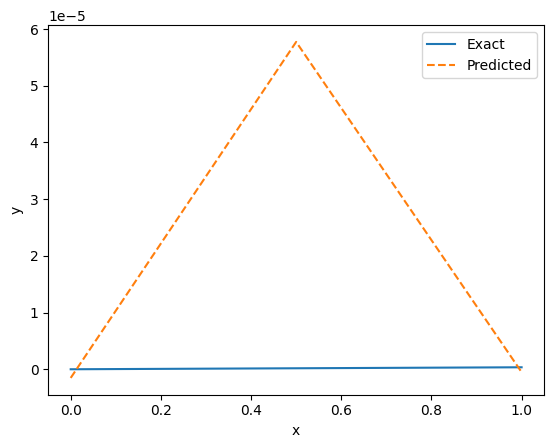

[2024-07-12 16:36:10.731098] initial (min) loss is 10389.3486328125
[2024-07-12 16:40:17.862091] No improvement in 1000 steps
[2024-07-12 16:40:17.863091] Step = 22986 loss = 0.000001 normalized loss line= -416.278693x+30848.584406. There was 1 stop dings already.
[2024-07-12 16:40:31.204092] No improvement in 1000 steps
[2024-07-12 16:40:31.204092] Step = 24230 loss = 0.000001 normalized loss line= -0.351363x+26.489260. There was 2 stop dings already.
[2024-07-12 16:40:43.222094] No improvement in 1000 steps
[2024-07-12 16:40:43.222094] Step = 25230 loss = 0.000003 normalized loss line= -0.735410x+52.772261. There was 3 stop dings already.
[2024-07-12 16:40:55.251092] No improvement in 1000 steps
[2024-07-12 16:40:55.251092] Step = 26230 loss = 0.000011 normalized loss line= -0.000132x+0.085393. There was 4 stop dings already.
[2024-07-12 16:41:06.634093] No improvement in 1000 steps
[2024-07-12 16:41:06.634093] Step = 27230 loss = 0.000001 normalized loss line= -0.550909x+44.122326. 

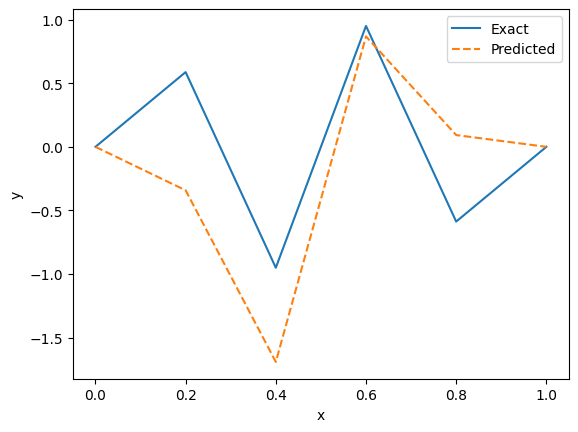

[2024-07-12 16:41:06.805093] initial (min) loss is 11081.1220703125
[2024-07-12 16:45:55.175556] No improvement in 1000 steps
[2024-07-12 16:45:55.175556] Step = 26515 loss = 0.001057 normalized loss line= 0.014224x+1.222953. There was 1 stop dings already.
[2024-07-12 16:46:05.907562] No improvement in 1000 steps
[2024-07-12 16:46:05.907562] Step = 27515 loss = 0.001222 normalized loss line= -0.105034x+8.693139. There was 2 stop dings already.
[2024-07-12 16:46:16.629562] No improvement in 1000 steps
[2024-07-12 16:46:16.630561] Step = 28515 loss = 0.000012 normalized loss line= 0.696263x+28.701360. There was 3 stop dings already.
[2024-07-12 16:46:27.344558] No improvement in 1000 steps
[2024-07-12 16:46:27.344558] Step = 29515 loss = 0.000031 normalized loss line= 0.153471x+14.555362. There was 4 stop dings already.
[2024-07-12 16:46:38.125145] No improvement in 1000 steps
[2024-07-12 16:46:38.125145] Step = 30515 loss = 0.000671 normalized loss line= 0.193014x+-2.053341. There was 

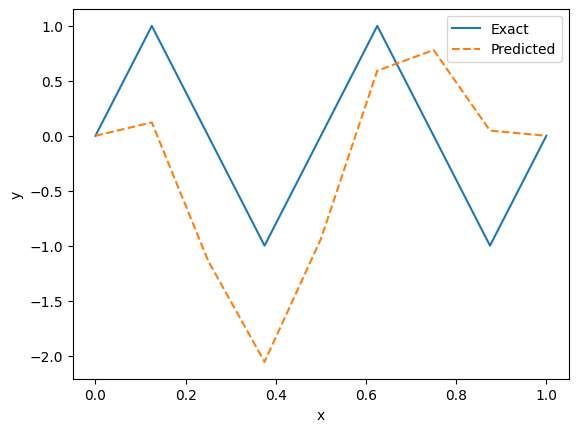

[2024-07-12 16:46:38.281122] initial (min) loss is 11334.3349609375
[2024-07-12 16:48:46.789712] No improvement in 1000 steps
[2024-07-12 16:48:46.789712] Step = 11946 loss = 0.000104 normalized loss line= 0.010058x+-0.310490. There was 1 stop dings already.
[2024-07-12 16:48:57.581707] No improvement in 1000 steps
[2024-07-12 16:48:57.582712] Step = 12946 loss = 0.000580 normalized loss line= -0.030261x+2.310858. There was 2 stop dings already.
[2024-07-12 16:49:16.280683] No improvement in 1000 steps
[2024-07-12 16:49:16.280683] Step = 14678 loss = 0.002732 normalized loss line= -0.000001x+0.000105. There was 3 stop dings already.
[2024-07-12 16:49:44.555501] No improvement in 1000 steps
[2024-07-12 16:49:44.555501] Step = 17294 loss = 0.000040 normalized loss line= 0.574693x+-4.897776. There was 4 stop dings already.
[2024-07-12 16:49:55.357469] No improvement in 1000 steps
[2024-07-12 16:49:55.358469] Step = 18294 loss = 0.000008 normalized loss line= -0.160951x+12.262953. There wa

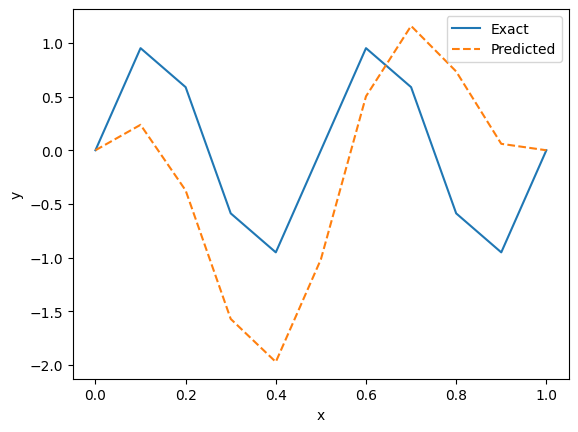

[2024-07-12 16:49:55.522500] initial (min) loss is 12163.232421875
[2024-07-12 17:21:29.904337] No improvement in 1000 steps
[2024-07-12 17:21:29.904337] Step = 176788 loss = 0.000079 normalized loss line= -0.480944x+38.452004. There was 1 stop dings already.
[2024-07-12 17:27:21.019342] No improvement in 1000 steps
[2024-07-12 17:27:21.019342] Step = 209902 loss = 0.000029 normalized loss line= -3.216973x+295.155371. There was 2 stop dings already.
[2024-07-12 17:28:56.352312] No improvement in 1000 steps
[2024-07-12 17:28:56.352312] Step = 218933 loss = 0.000036 normalized loss line= 1.246609x+26.032741. There was 3 stop dings already.
[2024-07-12 17:32:17.993338] No improvement in 1000 steps
[2024-07-12 17:32:17.993338] Step = 237978 loss = 0.000017 normalized loss line= 9.642953x+-246.544627. There was 4 stop dings already.
[2024-07-12 17:33:28.631342] No improvement in 1000 steps
[2024-07-12 17:33:28.632344] Step = 244640 loss = 0.006933 normalized loss line= -0.000942x+0.303593. 

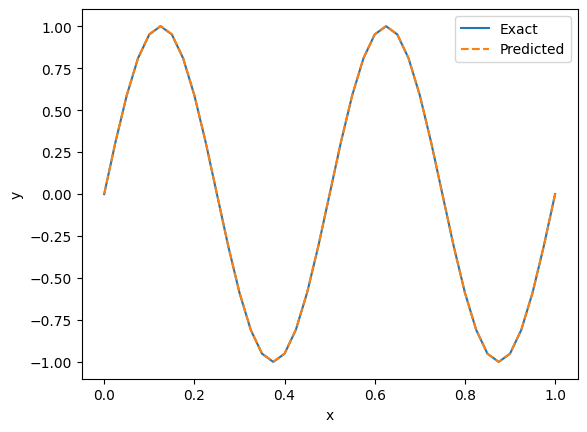

[2024-07-12 17:33:28.831312] initial (min) loss is 12292.3603515625
[2024-07-12 18:23:22.384337] No improvement in 1000 steps
[2024-07-12 18:23:22.384337] Step = 282156 loss = 0.000036 normalized loss line= -0.000006x+1.000482. There was 1 stop dings already.
[2024-07-12 18:25:48.734342] No improvement in 1000 steps
[2024-07-12 18:25:48.734342] Step = 295949 loss = 0.000035 normalized loss line= -0.000000x+1.001384. There was 2 stop dings already.
[2024-07-12 18:28:05.633345] No improvement in 1000 steps
[2024-07-12 18:28:05.633345] Step = 308858 loss = 0.000034 normalized loss line= -0.000004x+1.001999. There was 3 stop dings already.
[2024-07-12 18:31:42.531343] No improvement in 1000 steps
[2024-07-12 18:31:42.531343] Step = 329408 loss = 0.000033 normalized loss line= -0.000005x+1.000682. There was 4 stop dings already.
[2024-07-12 18:31:57.531337] No improvement in 1000 steps
[2024-07-12 18:31:57.531337] Step = 330820 loss = 0.000033 normalized loss line= 0.000001x+1.001179. There

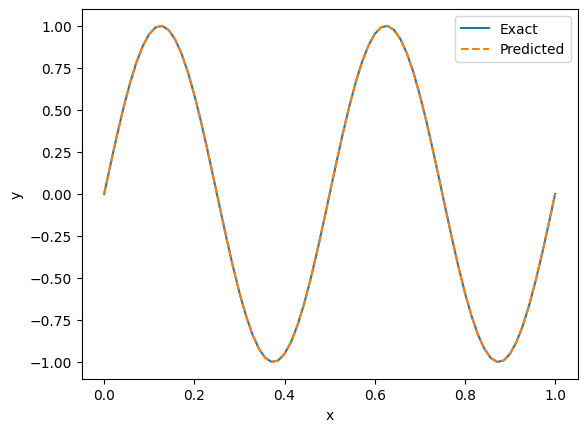

[2024-07-12 18:31:57.763312] initial (min) loss is 12343.376953125
[2024-07-12 19:11:40.076336] No improvement in 1000 steps
[2024-07-12 19:11:40.076336] Step = 225451 loss = 0.000026 normalized loss line= -0.000015x+1.000519. There was 1 stop dings already.
[2024-07-12 19:13:45.282338] No improvement in 1000 steps
[2024-07-12 19:13:45.282338] Step = 237287 loss = 0.000025 normalized loss line= 0.000001x+0.999864. There was 2 stop dings already.
[2024-07-12 19:14:31.000312] No improvement in 1000 steps
[2024-07-12 19:14:31.000312] Step = 241609 loss = 0.000025 normalized loss line= -0.000008x+0.999964. There was 3 stop dings already.
[2024-07-12 19:15:49.076336] No improvement in 1000 steps
[2024-07-12 19:15:49.076336] Step = 248988 loss = 0.000024 normalized loss line= -0.000002x+1.000606. There was 4 stop dings already.
[2024-07-12 19:16:48.627341] No improvement in 1000 steps
[2024-07-12 19:16:48.627341] Step = 254622 loss = 0.000024 normalized loss line= -0.000006x+1.000952. There 

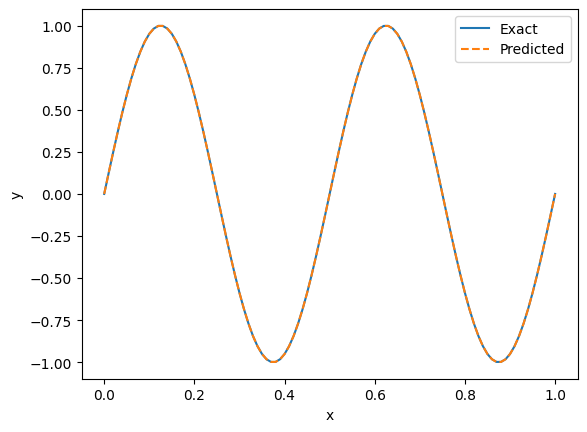

[2024-07-12 19:16:48.871312] initial (min) loss is 12438.654296875
[2024-07-12 19:36:01.513336] No improvement in 1000 steps
[2024-07-12 19:36:01.514334] Step = 107930 loss = 0.003550 normalized loss line= -0.030274x+2.239368. There was 1 stop dings already.
[2024-07-12 19:37:14.720312] No improvement in 1000 steps
[2024-07-12 19:37:14.720312] Step = 114775 loss = 0.000922 normalized loss line= 0.012153x+2.740440. There was 2 stop dings already.
[2024-07-12 19:47:49.846312] No improvement in 1000 steps
[2024-07-12 19:47:49.847312] Step = 174096 loss = 0.000087 normalized loss line= -0.223163x+22.735122. There was 3 stop dings already.
[2024-07-12 19:48:15.491313] No improvement in 1000 steps
[2024-07-12 19:48:15.491313] Step = 176504 loss = 0.000069 normalized loss line= -1.803005x+131.092874. There was 4 stop dings already.
[2024-07-12 20:11:22.901342] No improvement in 1000 steps
[2024-07-12 20:11:22.902341] Step = 306488 loss = 0.000043 normalized loss line= -0.000002x+1.000806. The

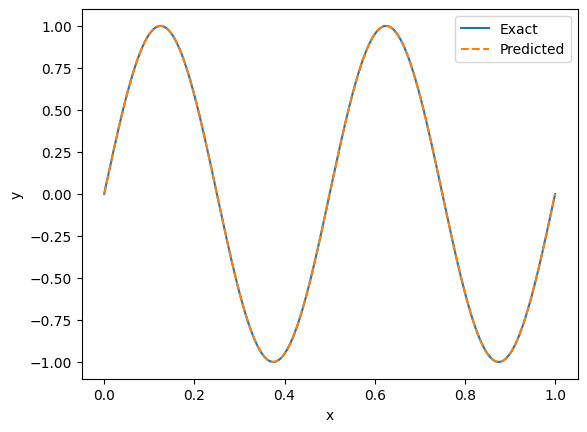

[2024-07-12 20:11:23.438312] initial (min) loss is 12450.9619140625
[2024-07-12 21:24:25.314337] No improvement in 1000 steps
[2024-07-12 21:24:25.314337] Step = 416386 loss = 0.000064 normalized loss line= -0.000003x+1.001272. There was 1 stop dings already.
[2024-07-12 21:30:51.132345] No improvement in 1000 steps
[2024-07-12 21:30:51.132345] Step = 452976 loss = 0.000056 normalized loss line= -0.000003x+1.000293. There was 2 stop dings already.
[2024-07-12 21:35:07.870367] No improvement in 1000 steps
[2024-07-12 21:35:07.870367] Step = 477240 loss = 0.000052 normalized loss line= 0.000002x+1.000384. There was 3 stop dings already.
[2024-07-12 21:37:51.377312] No improvement in 1000 steps
[2024-07-12 21:37:51.377312] Step = 492661 loss = 0.000049 normalized loss line= -0.000001x+1.000790. There was 4 stop dings already.
[2024-07-12 21:38:33.958312] No improvement in 1000 steps
[2024-07-12 21:38:33.959341] Step = 496687 loss = 0.000049 normalized loss line= -0.000010x+1.002358. There

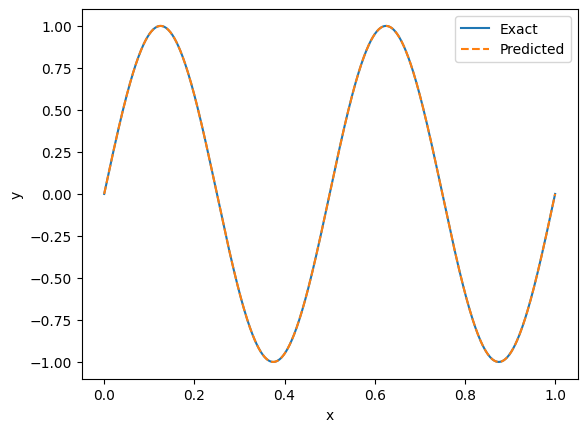

[2024-07-12 21:38:34.789312] initial (min) loss is 12457.4794921875
[2024-07-12 22:47:50.577343] No improvement in 1000 steps
[2024-07-12 22:47:50.578312] Step = 392669 loss = 0.000032 normalized loss line= -0.000006x+1.000761. There was 1 stop dings already.
[2024-07-12 22:50:43.812336] No improvement in 1000 steps
[2024-07-12 22:50:43.812336] Step = 409034 loss = 0.000030 normalized loss line= -0.000003x+1.000490. There was 2 stop dings already.
[2024-07-12 22:55:03.141337] No improvement in 1000 steps
[2024-07-12 22:55:03.141337] Step = 433552 loss = 0.000028 normalized loss line= -0.000002x+1.000153. There was 3 stop dings already.
[2024-07-12 22:55:33.727343] No improvement in 1000 steps
[2024-07-12 22:55:33.727343] Step = 436437 loss = 0.000028 normalized loss line= -0.000006x+1.000719. There was 4 stop dings already.
[2024-07-12 22:57:48.012336] No improvement in 1000 steps
[2024-07-12 22:57:48.012336] Step = 449126 loss = 0.000027 normalized loss line= -0.000009x+1.000847. Ther

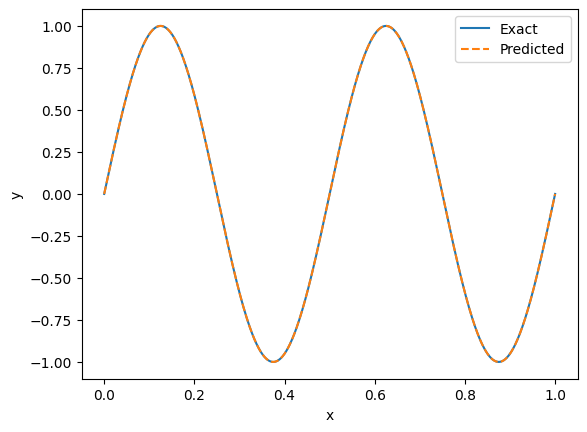

[2024-07-12 22:57:49.164312] initial (min) loss is 12463.8203125
[2024-07-12 23:35:17.070312] No improvement in 1000 steps
[2024-07-12 23:35:17.070312] Step = 204696 loss = 0.000067 normalized loss line= -0.000003x+1.000585. There was 1 stop dings already.
[2024-07-12 23:36:40.910336] No improvement in 1000 steps
[2024-07-12 23:36:40.910336] Step = 212324 loss = 0.000065 normalized loss line= -0.000004x+1.000628. There was 2 stop dings already.
[2024-07-12 23:38:37.411336] No improvement in 1000 steps
[2024-07-12 23:38:37.411336] Step = 222940 loss = 0.000063 normalized loss line= -0.000002x+1.000397. There was 3 stop dings already.
[2024-07-12 23:39:11.054342] No improvement in 1000 steps
[2024-07-12 23:39:11.054342] Step = 226011 loss = 0.000062 normalized loss line= -0.000003x+1.000270. There was 4 stop dings already.
[2024-07-12 23:46:05.997342] No improvement in 1000 steps
[2024-07-12 23:46:05.997342] Step = 263825 loss = 0.000056 normalized loss line= -0.000002x+1.000379. There w

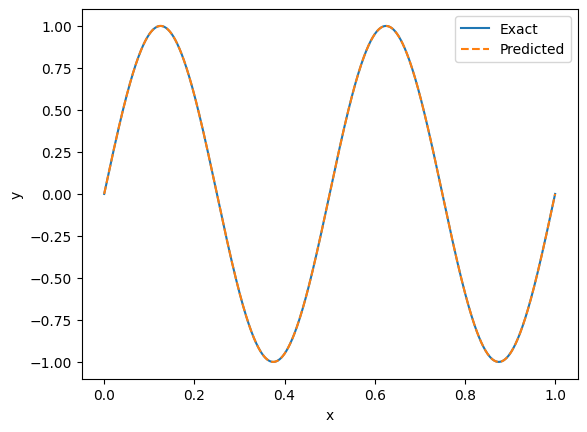

[2024-07-12 23:46:11.371312] initial (min) loss is 12467.73828125
[2024-07-13 00:28:35.790399] No improvement in 1000 steps
[2024-07-13 00:28:35.791399] Step = 229870 loss = 0.000036 normalized loss line= -0.000008x+1.001432. There was 1 stop dings already.
[2024-07-13 00:29:10.125399] No improvement in 1000 steps
[2024-07-13 00:29:10.125399] Step = 233382 loss = 0.000035 normalized loss line= -0.000007x+1.001196. There was 2 stop dings already.
[2024-07-13 00:30:29.074399] No improvement in 1000 steps
[2024-07-13 00:30:29.074399] Step = 241427 loss = 0.000034 normalized loss line= -0.000008x+1.000938. There was 3 stop dings already.
[2024-07-13 00:31:15.483399] No improvement in 1000 steps
[2024-07-13 00:31:15.484399] Step = 246178 loss = 0.000033 normalized loss line= -0.000006x+1.001272. There was 4 stop dings already.
[2024-07-13 00:31:52.997399] No improvement in 1000 steps
[2024-07-13 00:31:52.997399] Step = 250036 loss = 0.000032 normalized loss line= -0.000005x+1.000950. There 

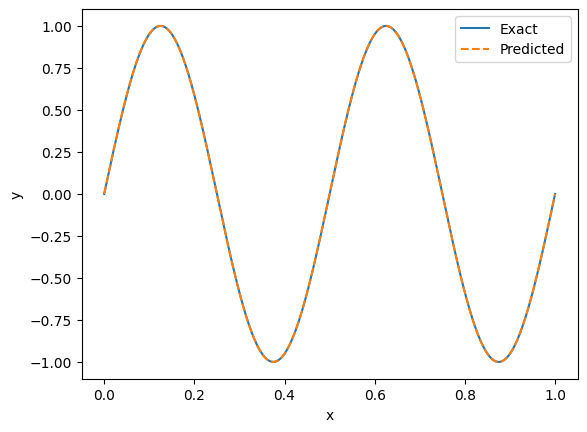

[2024-07-13 00:32:02.858398] initial (min) loss is 12466.4365234375
[2024-07-13 01:09:30.992584] No improvement in 1000 steps
[2024-07-13 01:09:30.992584] Step = 221306 loss = 0.000096 normalized loss line= -0.000004x+1.000413. There was 1 stop dings already.
[2024-07-13 01:10:25.969584] No improvement in 1000 steps
[2024-07-13 01:10:25.969584] Step = 226602 loss = 0.000095 normalized loss line= -0.000003x+1.000349. There was 2 stop dings already.
[2024-07-13 01:13:03.436685] No improvement in 1000 steps
[2024-07-13 01:13:03.437684] Step = 241854 loss = 0.000090 normalized loss line= -0.000004x+1.000601. There was 3 stop dings already.
[2024-07-13 01:16:39.473057] No improvement in 1000 steps
[2024-07-13 01:16:39.473057] Step = 262976 loss = 0.000084 normalized loss line= -0.000004x+1.000633. There was 4 stop dings already.
[2024-07-13 01:17:31.863057] No improvement in 1000 steps
[2024-07-13 01:17:31.863057] Step = 268064 loss = 0.000083 normalized loss line= -0.000003x+1.000532. Ther

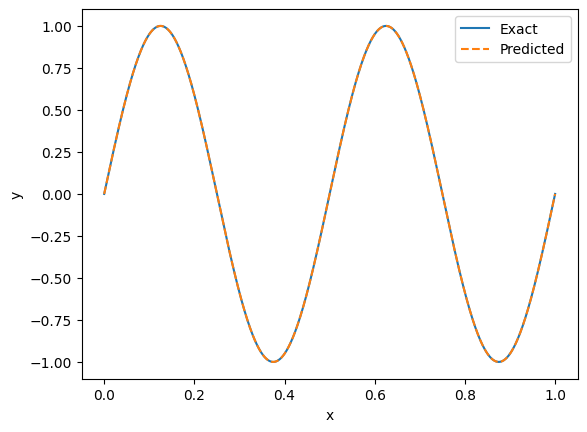

In [5]:
import pandas as pd

exp_dict_list=[]

nruns = 1

for N in grid_n:
    for _ in range(nruns):
        exp_dict_list.append(experiment(N))

#exp_dict_list_flatten = [item for sublist in exp_dict_list for item in sublist]
#df = pd.DataFrame(exp_dict_list_flatten)
#df.to_csv('poisson_PINN_PSO.csv')

In [ ]:
import pandas as pd

exp_dict_list=[]

nruns = 1

for N in grid_n:
    for _ in range(nruns):
        exp_dict_list.append(experiment_PSO(N))

exp_dict_list_flatten = [item for sublist in exp_dict_list for item in sublist]
df = pd.DataFrame(exp_dict_list_flatten)
df.to_csv('poisson_PINN_PSO.csv')

### графики

In [ ]:
from ast import literal_eval

df_pinn = pd.read_csv('poisson_PINN.csv')
y = []
for i in df_pinn['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: PINN')
plt.plot(df_pinn['grid_res'], y, '-o', label='loss PINN')
plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-o', label='l2_norm')
plt.plot(df_pinn['grid_res'], df_pinn['lu_f'], '-o', label='(lu-f,lu-f)')
plt.plot(df_pinn['grid_res'], df_pinn['lu'], '-o', label='(lu,lu)=(f,f)')
plt.yscale('log')
plt.xscale('log')
plt.title('Poisson autograd')
plt.legend()

In [ ]:
df_pinn = pd.read_csv('poisson_PINN_PSO.csv')
y = []
for i in df_pinn['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: PINN')
plt.plot(df_pinn['grid_res'], y, '-o', label='loss PSO')
plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-o', label='l2_norm_PSO')
plt.plot(df_pinn['grid_res'], df_pinn['l2_pinn']**2, '-o', label='l2_norm_PINN')
plt.plot(df_pinn['grid_res'], df_pinn['lu_f'], '-o', label='(lu-f,lu-f)')
plt.plot(df_pinn['grid_res'], df_pinn['lu'], '-o', label='(lu,lu)=(f,f)')
plt.yscale('log')
plt.xscale('log')
plt.title('Poisson PSO autograd')
plt.legend()

In [ ]:
df_pinn = pd.read_csv('poisson_PINN_lam.csv')
y = []
for i in df_pinn['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: PINN')
plt.plot(df_pinn['grid_res'], y, '-o', label='loss lam')
plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-o', label='l2_norm_lam')
# plt.plot(df_pinn['grid_res'], df_pinn['l2_pinn']**2, '-o', label='l2_norm_PINN')
plt.plot(df_pinn['grid_res'], df_pinn['lu_f'], '-o', label='(lu-f,lu-f)')
plt.plot(df_pinn['grid_res'], df_pinn['lu'], '-o', label='(lu,lu)=(f,f)')
plt.yscale('log')
plt.xscale('log')
plt.title('Poisson adaptibe lam autograd')
plt.legend()

In [ ]:
df_natG = pd.read_csv('poisson_NGD.csv')
# y = []
# for i in df_natG['l2_loss']:
#     y.append(literal_eval(i)[0])

df_pinn = pd.read_csv('poisson_PINN_PSO.csv')

plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-o', label='l2_norm_PSO')
plt.plot(df_pinn['grid_res'], df_pinn['l2_pinn']**2, '-o', label='l2_norm_PINN')
# plt.plot(df_natG['grid_res'], y, '-o', label='loss nat Grad')
plt.plot(df_natG['grid_res'], df_natG['error_test_NGD']**2, '-o', label='l2_norm_natG')

plt.yscale('log')
plt.xscale('log')
plt.title('Poisson equation')
plt.legend()
plt.show()